Importing Packages And Basic Set up

In [2]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler  
from plotnine import *
from matplotlib.pyplot import hist

import numpy as np
import pandas as pd

np.random.seed(23)

Importing Datasets

In [14]:
# Importing maindata

file_path = "C://Users//soren/Downloads/"

x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Datasets, only interested in the 1997 states. 

In [80]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think
#age_subset = np.logical_and(np.greater_equal(basic_merged["a_age"],18), np.greater_equal(19,basic_merged["a_age"]))
# 17 <= age <= 21 (maybe should be like 22)
#basic_merged = basic_merged[age_subset]
#print(basic_merged.shape)

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# I also drop the never states, as they may be substantively different from others, although this can be relaxed later.
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to intbasic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("never")==False]  # Only want to look at one for now. 

# Drop Arizona since they implemented late and later repealed policy
basic_merged = basic_merged[basic_merged["stfips"] != 5]

# As we are treating >19 as the never-treated group, we set their year implemented as 1000000 >> 1999
year_implemented_vector = basic_merged["Year_Implemented"].copy()
year_implemented_vector[basic_merged["under19"] == 0] = 1000000
basic_merged["group"] = year_implemented_vector  # Equals the year you were first treated. If >=19 then treated at t = infty

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["fownu18", "a_maritl", "female" , "povll"]#, "stfips"]
list_of_confounders += ["anykids", "disability", "collgrad", "hsgrad"] # removed coll + hs for now 

$\underline{\bold{\text{Estimating causal effect}}}$

Subsetting data

Fitting Model

In [17]:
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, year_of_interest:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each set of covariates in fold j
    3b. Each set of covariates is fitted for each combination of year x treatment
    4. We return a matrix which contains those predictions as columns (each column is one combinatino of year x treatment)
    5. We also return vectors which indicate the true year/treatment status for that particular set of covariates
    

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    year_of_interest: year that treatment occured
    '''
    # Setting up prediction vectors
    # the 2*i'th column is year `i` with treatment = 0
    # the (2*i)+1'th column is year `i` with treatment = 1
    # As we predict for 18 years, there are 36 columns. 

    predictions_matrix = np.empty(shape=(y.shape[0], 36))

    # k-folding
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # Creating lists to store the accuracy
    score = []

    # Generating vectors which will contain the true treatment/year combination for each covariate. 
    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)

    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        X_test = X_w_treatment.loc[test_index]
        y_test = y.loc[test_index]
        q = make_model()
        q.fit(X_train, y_train)
        score.append(q.score(X_test, y_test))

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1 (we want ATT, not ATE)
        treat_vec[test_index] = A.loc[test_index]

        for j in range(1991, 2009):
            X0 = X_w_treatment.copy()
            X0["A"] = 1000000  # Never treated units. 
            X0["year"] = j # Changing the year to the year of interest
            col_num = 2*(j - 1991)  # Which column the data should go in
            predictions_matrix[test_index,col_num] = q.predict_proba(X0.loc[test_index])[:, 1]
        for j in range(1991,2009):
            X1 = X_w_treatment.copy() 
            # We do not adjust the year here, as we are only interested in their actual treatment status
            # That means we don't need to change it, as it is already how we want it. 
            X1["year"] = j # Changing the year to the year of interest
            col_num = 2*(j - 1991) + 1  # Which column the data should go in
            predictions_matrix[test_index,col_num] = q.predict_proba(X1.loc[test_index])[:, 1]

    avg_score = sum(score)/len(score)

    assert np.isnan(predictions_matrix).sum() == 0  # Sanity check that we have no missings
    return predictions_matrix, year_vec, treat_vec, avg_score

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int, year_of_interest:int):
    # k-folding
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # group of people 
    G_g_and_C = np.logical_or(np.equal(A,year_of_interest), np.equal(A,1000000))

    # subset for people in G_g or C, then reset index to allow for kfolding
    covariates = X.copy()
    covariates = covariates.loc[G_g_and_C]
    covariates = covariates.reset_index(drop=True)

    # Creating list to store the accuracy
    score = []

    treatment_status = (A == year_of_interest)
    treatment_status = treatment_status.loc[G_g_and_C]
    treatment_status = treatment_status.reset_index(drop=True)

    g_matrix = np.full_like(treatment_status, np.nan, dtype=float)

    # Generating vectors which will contain the true treatment/year combination for each covariate. 
    # Normalizing years so that year =1 when treatment first occurs. 
    #covariates.drop("year", axis=1)  # We are interested in the covariates, not the year they were found in. 

    for train_index, test_index in kf.split(covariates, treatment_status):
        X_train = covariates.loc[train_index]
        y_train = treatment_status.loc[train_index]
        X_test = covariates.loc[test_index]
        y_test = treatment_status.loc[test_index]
        g = make_model()
        g.fit(X_train, y_train)
        score.append(g.score(X_test, y_test))
        g_matrix[test_index] = g.predict_proba(covariates.loc[test_index])[:, 1]
    assert np.isnan(g_matrix).sum() == 0  # Sanity check that we have no missings
    print("Max p:" + str(np.max(g_matrix))) # Checking for overlap
    hist(g_matrix, density=True)
    avg_score = sum(score)/len(score)
    return g_matrix, avg_score

Define models to Use

In [24]:
def logistic():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return LogisticRegression(random_state=42)

def randf():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(random_state=42, n_estimators=100, max_depth=2)

def randf_3():
    ''' A function that returns a general ML q model for later use in k-folding
        The same random forest as above but initialized with a different seed as a 
        robustness check'''
    return RandomForestClassifier(random_state=3, n_estimators=100, max_depth=5)

def large_randf():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

def mlp():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return MLPClassifier(solver='adam', hidden_layer_sizes=(15,), random_state=1, max_iter=500)

def xgb_100():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return XGBClassifier()

def xgb_100_5():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return XGBClassifier(n_estimators = 100, max_depth = 5)

def xgb_200():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return XGBClassifier(n_estimators = 200)

def adab():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return AdaBoostClassifier()

def extra_trees():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return ExtraTreesClassifier(random_state=42)

Estimating the ATT's


In [21]:
def ATT_event_study(year_of_interest:int, response:str, confounder_list:list, dataframe:pd.DataFrame, G_model, Q_model):
    '''
    Estimates ATT(g,t) for the combinations of g,t which we are interested in. 

    Based on Callaway & Sant'anna, we compute ATT(g,t) over time

    We say that ATT(g,t) is the ATT for group g at time `t`
    We compare the outcomes at time `t` to a base date, which we refer to as g_d_1
    
    If time `t` occurs >= treatment_year (i.e. when treatment first occurs), then g_d_1 = treatment_year - 1
    Otherwise, we say that g_d_1 = t - 1

    For intuition, if t >= treatment_year, we are looking at the DiD comparing outcomes at time `t` to 
    those which were immediately before treatment. If t < treatment_year, then we are performing a robustness check.
    That robustness check involves pretending that treatment occured at time t, and comparing it to the previous period's outcomes. 

    For each g,t of interest, we compute:

    ATT(g,t) = E(G_g/E(G_g) * (m_treat_1(X) - m_treat_0(X) - (m_nev_1(X) - m_nev_0(X))))

    m_treat_i(X) = prediction for the outcome for an individual with covariates `X` in year `t` who recieved treatment = `i`
    m_nev_i(X)   = prediction for the outcome for an individual with covariates `X` in year `g_d_1` who recieved treatment = `i`

    We also compute standard errors, and return the ATT(g,t) + standard errors as two different lists. 

    stfips: the FIPS codes for the states of interest
    year_of_interest: the year at which treatment first occurs
    response: which outcome we are interested in, out of public/private/all insurance. 
    confounder_list: list of columns of dataframe to use as confounders
    dataframe: dataframe to get data from
    model: machine learning ensemble model to use as the Q model
    '''
    # We don't subset here, as we want to fit on all data. 
    #state_level = dataframe.loc[dataframe['stfips'].isin(stfips),:] # Subset for states of interest
    results_df = {}
    state_level = dataframe.copy()
    state_level = state_level[confounder_list+ ["group","year", response]]  # Subsetting for features of interest

    # Drop missings, only needed for some models, 
    state_level = state_level.dropna(axis = 0)

    # Setting up 
    state_level = state_level.reset_index(drop=True)
    confounders = state_level[list_of_confounders + ["year"]]
    treatment = state_level["group"]
    outcome = state_level[response]

    predictions_matrix, year_vec, treat_vec, q_avg_score = outcome_k_fold_fit_and_predict(Q_model, \
                                       X=confounders, y=outcome, A=treatment, n_splits=5, \
                                        year_of_interest=year_of_interest)
                                        
    G_g_and_C = np.logical_or(np.equal(treatment,year_of_interest), np.equal(treatment,1000000))

    predictions_matrix = predictions_matrix[G_g_and_C,:]
    year_vec = year_vec[G_g_and_C]
    treat_vec = treat_vec[G_g_and_C]
    outcome = outcome[G_g_and_C]

    # the 2*i'th column is always the untreated vec, and the (2*i)+1 is treated. 
    g_matrix, g_avg_score = treatment_k_fold_fit_and_predict(G_model, X=confounders, A=treatment, n_splits=5, \
                                                year_of_interest=year_of_interest)
                                                
    # Weight on the first term. 
    # This depends only on g so we can pull it out here
    w_g = (treat_vec == year_of_interest) #* (year_vec == year) # We only want the ATT, so we weight appropriately
                                                # to only look at the untils treated at t=1
    w_g = w_g / np.mean(w_g) # To ensure mean of the weights is 1, weights are >= 0 by construction
    
    for i in range(1,18): # we look at the ATT for 1992-2008 (cannot look at 1991 as we have no 1990 data)
        year = i + 1991 # What actual year we are looking at in the for loop
        # Generating term 1:
        m_treat_1 = predictions_matrix[:,(2*i)+1]  # m_treat_1 
        m_nev_1 = predictions_matrix[:,(2*i)]  # m_nev_1
        if year >= year_of_interest: # If we've gotten to the treatment year 
            m_treat_0 = predictions_matrix[:,(2*(year_of_interest-1991))-1]  # m_treat_0
            m_nev_0 = predictions_matrix[:,(2*(year_of_interest-1991))-2]  # m_nev_0
        else:  # otherwise we do a short difference. 
            m_treat_0 = predictions_matrix[:,(2*i)-1]  # m_treat_0
            m_nev_0 = predictions_matrix[:,(2*i)-2]  # m_nev_0
        term_1 = w_g * (m_treat_1 - m_treat_0 - (m_nev_1 - m_nev_0))  

        # Generating term 2:
        # This weight equals 1 if the unit appears at time t and is in group g
        w_treat_1 = (year_vec == year) * (treat_vec == year_of_interest)  # Equals 1 if in year, and treated at year_of_interest

        w_treat_1 = w_treat_1 / np.mean(w_treat_1)

        # This weight equals 1 if the unit appears at time g_d_1 and is in group g
        if year >= year_of_interest: # If we've gotten to the treatment year
            w_treat_0 = (year_vec == year_of_interest - 1) * (treat_vec == year_of_interest)  # Equals 1 if in year, and treated at year_of_interest
            w_treat_0 = w_treat_0 / np.mean(w_treat_0)
        else:
            w_treat_0 = (year_vec == year - 1) * (treat_vec == year_of_interest)  # Equals 1 if in year, and treated at year_of_interest
            w_treat_0 = w_treat_0 / np.mean(w_treat_0)

        term_2 = w_treat_1 * (outcome - m_treat_1) - w_treat_0 * (outcome - m_treat_0)
        
        # Generating term 3:
        w_nev_1 = (year_vec == year) * (treat_vec >= 2002) * g_matrix / (1 - g_matrix)

        w_nev_1 = w_nev_1 / np.mean(w_nev_1)
        
        if year >= year_of_interest:
            w_nev_0 = (year_vec == year_of_interest - 1) * (treat_vec >= 3000) * g_matrix / (1 - g_matrix)
            w_nev_0 = w_nev_0 / np.mean(w_nev_0)
        else:
            w_nev_0 = (year_vec == year - 1) * (treat_vec >= 3000) * g_matrix / (1 - g_matrix)
            w_nev_0 = w_nev_0 / np.mean(w_nev_0)
        
        term_3 = w_nev_1 * (outcome - m_nev_1) - w_nev_0 * (outcome - m_nev_0)

        # Multiplying by 100 to convert to %
        #mean = (np.mean(term_1) + np.mean(term_2) - np.mean(term_3)) * 100 
        final = term_1 + term_2 - term_3
        mean = np.mean(final) * 100

        # Computing standard error from the influence curve (final - np.mean(final) * A)
        # This assumes that they are iid, which is unrealistic.  Not sure how to weaken. 
        #ste = np.sqrt(np.var(term_1) + np.var(term_2) + np.var(term_3))*100 / np.sqrt(term_1.shape[0])
        ste = np.std(final) * 100 / np.sqrt(term_1.shape[0])

        results_df.setdefault('year',[]).append(i + 1991)
        results_df.setdefault('att',[]).append(mean)
        results_df.setdefault('std',[]).append(ste)
        results_df.setdefault('q_model',[]).append(Q_model.__name__ )
        results_df.setdefault('g_model',[]).append(G_model.__name__ )
        results_df.setdefault('q_accuracy',[]).append(q_avg_score)
        results_df.setdefault('g_accuracy',[]).append(g_avg_score)
        results_df.setdefault('response',[]).append(response)
        results_df.setdefault('treat_year',[]).append(year_of_interest)
    
    results_df = pd.DataFrame(results_df)

    return results_df

Max p:0.38074797904502167


,year,att,std,q_model,g_model,q_accuracy,g_accuracy,response,treat_year
0,1992,0.029947,0.837076,xgb_100,randf,0.903485,0.837147,pubonly,1999
1,1993,-0.276591,0.865746,xgb_100,randf,0.903485,0.837147,pubonly,1999
2,1994,-0.504713,0.896719,xgb_100,randf,0.903485,0.837147,pubonly,1999
3,1995,0.610590,0.934981,xgb_100,randf,0.903485,0.837147,pubonly,1999
4,1996,-0.105174,0.964256,xgb_100,randf,0.903485,0.837147,pubonly,1999


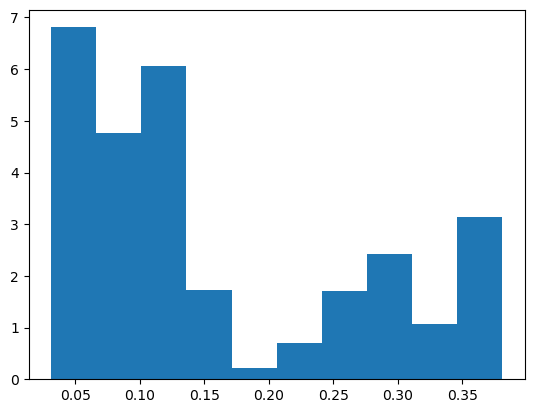

In [7]:
# Simple test to make sure the above functions work

# Get all states which implemented programs in that year
test_df = ATT_event_study(1999, "pubonly", list_of_confounders, basic_merged, randf, xgb_100)

test_df.head()

Max p:0.38074797904502167


,year,att,std,q_model,g_model,q_accuracy,g_accuracy,response,treat_year
0,1992,0.029947,0.837076,xgb_100,randf,0.903485,0.837147,pubonly,1999
1,1993,-0.276591,0.865746,xgb_100,randf,0.903485,0.837147,pubonly,1999
2,1994,-0.504713,0.896719,xgb_100,randf,0.903485,0.837147,pubonly,1999
3,1995,0.610590,0.934981,xgb_100,randf,0.903485,0.837147,pubonly,1999
4,1996,-0.105174,0.964256,xgb_100,randf,0.903485,0.837147,pubonly,1999


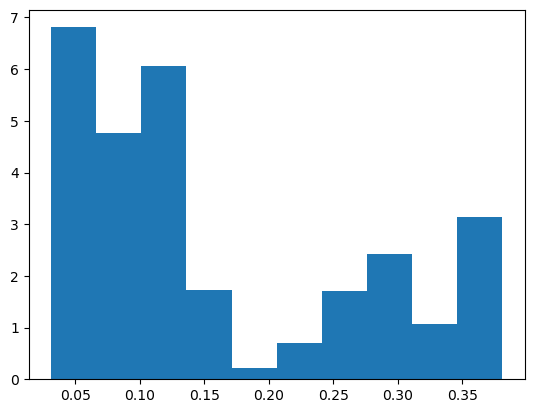

In [8]:
# Simple test to make sure the above functions work

# Get all states which implemented programs in that year
test_df = ATT_event_study(1999, "pubonly", list_of_confounders, basic_merged, randf, xgb_100)

test_df.head()

Max p:0.9604666933461384
Max p:0.9604666933461384
Max p:0.9604666933461384
Max p:0.9604666933461384
Max p:0.9604666933461384


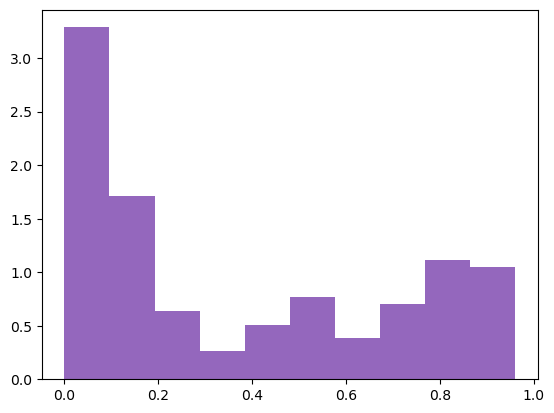

In [25]:
# Find a good Q model for the doubly robust estimator
# Test functions on 1998 since it has the most data, but don't compute for every
# year since that would take prohibitively long
all_models = pd.DataFrame()

for g_model in [large_randf]:
    for q_model in [logistic, large_randf, adab, xgb_100, extra_trees]:
        new_model = ATT_event_study(1998, "pubonly", list_of_confounders, basic_merged, g_model, q_model)
        all_models = pd.concat([all_models, new_model], ignore_index=True)

all_models.head()
all_models.to_csv("./ATT_Results/dr_1998_pubonly_all_models.csv")

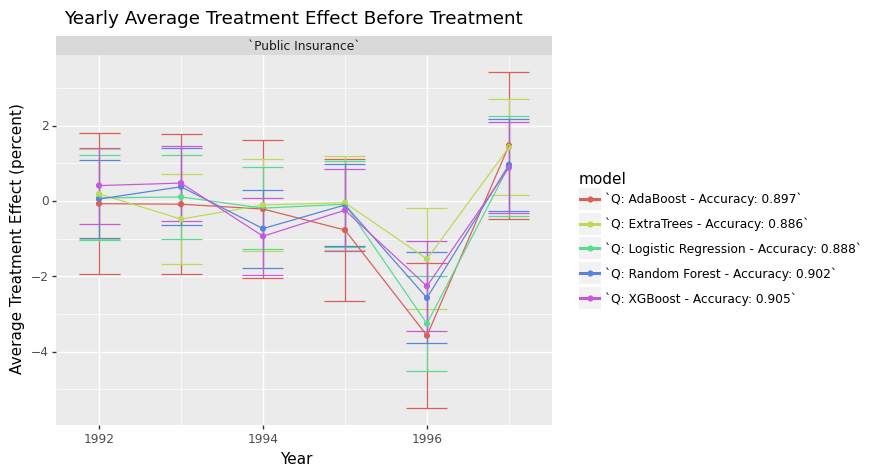

<ggplot: (136969015875)>

In [48]:
# Plotnine code to make plot for pre-treatment effects
all_models['adjusted_year'] = all_models["year"] - all_models["treat_year"]
all_models["response"] = all_models["response"].apply(lambda x: x.replace("pubonly", "`Public Insurance`"))
# Plotnine code to make plot for pre-treatment effects
all_models['adjusted_year'] = all_models["year"] - all_models["treat_year"]
all_pre_treat = all_models[(all_models['adjusted_year'] < 0)].copy()
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("adab", "AdaBoost"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("extra_trees", "ExtraTrees"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("large_randf", "Random Forest"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("logistic", "Logistic Regression"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("xgb_100", "XGBoost"))
all_pre_treat["model"] = "`Q: " + all_pre_treat["q_model"] + " - Accuracy: " + all_pre_treat["q_accuracy"].apply(lambda x: str(round(x,3))) +"`"
all_pre_treat['att-error'] = all_pre_treat['att'] - all_pre_treat['std']
all_pre_treat['att+error'] = all_pre_treat['att'] + all_pre_treat['std']
all_pre_treat['treat_year'] = all_pre_treat['treat_year'].apply(lambda x: str(x))

ggplot(all_pre_treat, aes(x='adjusted_year', y='att', color = 'model', group='model')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect (percent)') + \
labs(title = "Yearly Average Treatment Effect Before Treatment ")

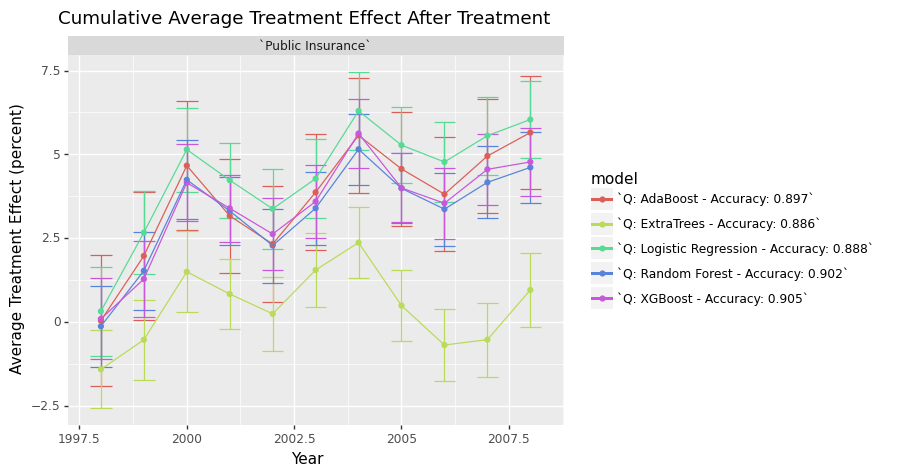

<ggplot: (136768315067)>

In [47]:
# Plotnine code to make plot for pre-treatment effects
all_models['adjusted_year'] = all_models["year"] - all_models["treat_year"]
all_pre_treat = all_models[(all_models['adjusted_year'] >= 0)].copy()
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("adab", "AdaBoost"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("extra_trees", "ExtraTrees"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("large_randf", "Random Forest"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("logistic", "Logistic Regression"))
all_pre_treat["q_model"] = all_pre_treat["q_model"].apply(lambda x: x.replace("xgb_100", "XGBoost"))
all_pre_treat["model"] = "`Q: " + all_pre_treat["q_model"] + " - Accuracy: " + all_pre_treat["q_accuracy"].apply(lambda x: str(round(x,3))) +"`"
all_pre_treat['att-error'] = all_pre_treat['att'] - all_pre_treat['std']
all_pre_treat['att+error'] = all_pre_treat['att'] + all_pre_treat['std']
all_pre_treat['treat_year'] = all_pre_treat['treat_year'].apply(lambda x: str(x))

ggplot(all_pre_treat, aes(x='year', y='att', color = 'model', group='model')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect (percent)') + \
labs(title = "Cumulative Average Treatment Effect After Treatment ")

In [3]:
# Find a good Q model for the doubly robust estimator
# Test functions on 1998 since it has the most data, but don't compute for every
# year since that would take prohibitively long
all_years = pd.DataFrame()

for year in [1997,1998,1999]:
    for response in ["pubonly","privonly","insured"]:
        new_model = ATT_event_study(year, response, list_of_confounders, basic_merged, large_randf, xgb_100)
        all_years = pd.concat([all_years, new_model], ignore_index=True)

all_years.head()

# For the g model Max p:0.7248093938018448

In [82]:
all_years.to_csv("./ATT_Results/dr_all_years.csv")

C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1836351283.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1836351283.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1836351283.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

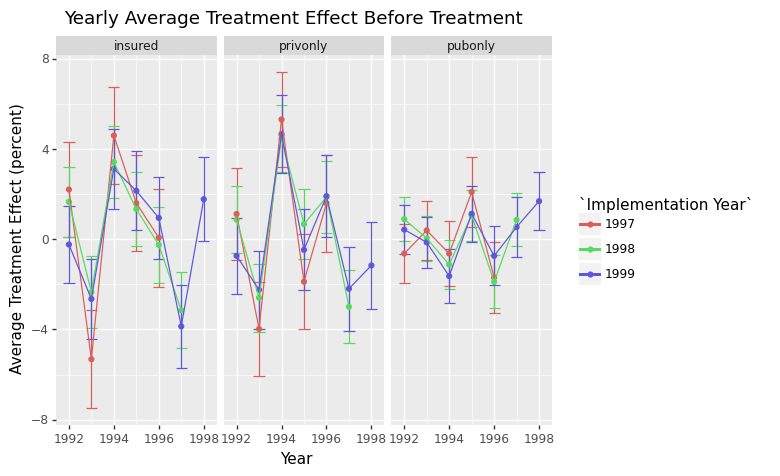

<ggplot: (136772334397)>

In [92]:
# Plotnine code to make plot for pre-treatment effects
#all_models["response"] = all_models["response"].apply(lambda x: x.replace("pubonly", "`Public Insurance`"))
# Plotnine code to make plot for pre-treatment effects
all_years_from_csv = pd.read_csv("ATT_Results/dr_all_years.csv")
all_years_from_csv['adjusted_year'] = all_years_from_csv["year"] - all_years_from_csv["treat_year"]
all_years_from_csv['`Implementation Year`'] = all_years_from_csv["treat_year"].apply(lambda x: str(x))
all_pre_treat = all_years_from_csv[(all_years_from_csv['adjusted_year'] < 0)]
all_pre_treat['att-error'] = all_pre_treat['att'] - all_pre_treat['std']
all_pre_treat['att+error'] = all_pre_treat['att'] + all_pre_treat['std']
all_pre_treat['treat_year'] = all_pre_treat['treat_year'].apply(lambda x: str(x))

ggplot(all_pre_treat, aes(x='year', y='att', color = '`Implementation Year`', group='`Implementation Year`')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect (percent)') + \
labs(title = "Yearly Average Treatment Effect Before Treatment ")

C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1942919212.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1942919212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1942919212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

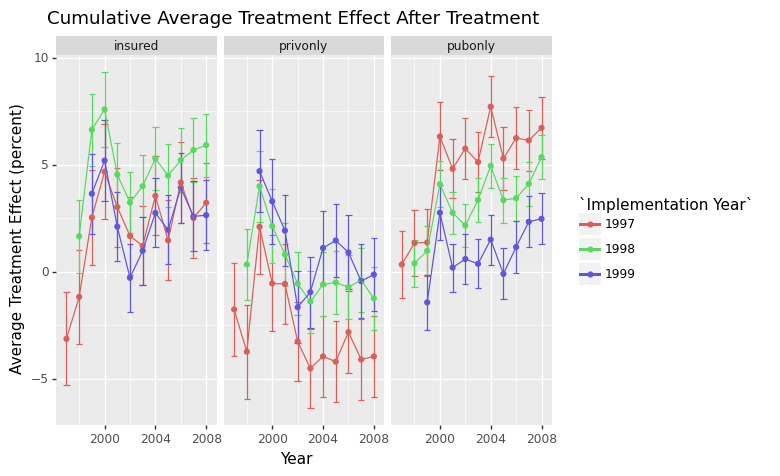

<ggplot: (136773779845)>

In [94]:
# Plotnine code to make plot for pre-treatment effects
#all_models["response"] = all_models["response"].apply(lambda x: x.replace("pubonly", "`Public Insurance`"))
# Plotnine code to make plot for pre-treatment effects
all_years_from_csv = pd.read_csv("ATT_Results/dr_all_years.csv")
all_years_from_csv['adjusted_year'] = all_years_from_csv["year"] - all_years_from_csv["treat_year"]
all_years_from_csv['`Implementation Year`'] = all_years_from_csv["treat_year"].apply(lambda x: str(x))
all_pre_treat = all_years_from_csv[(all_years_from_csv['adjusted_year'] >= 0)]
all_pre_treat['att-error'] = all_pre_treat['att'] - all_pre_treat['std']
all_pre_treat['att+error'] = all_pre_treat['att'] + all_pre_treat['std']
all_pre_treat['treat_year'] = all_pre_treat['treat_year'].apply(lambda x: str(x))

ggplot(all_pre_treat, aes(x='year', y='att', color = '`Implementation Year`', group='`Implementation Year`')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect (percent)') + \
labs(title = "Cumulative Average Treatment Effect After Treatment ")

C:\Users\soren\AppData\Local\Temp\ipykernel_27240\1198039711.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


Text(0, 0.5, 'Percent Increase from 1991')

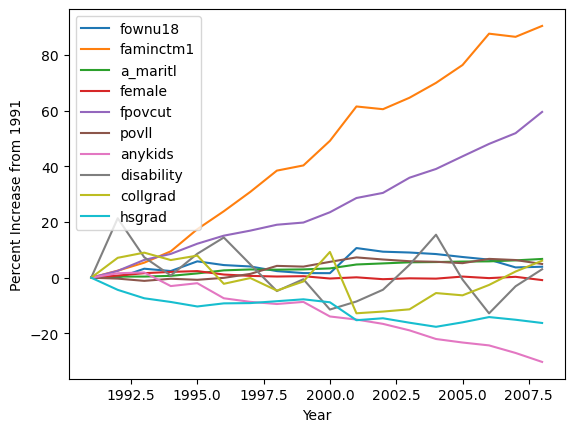

In [74]:
confounder_df = basic_merged.groupby(by=["year"], as_index=False).mean().copy()[list_of_confounders + ["year"]]
for confounder in list_of_confounders:
    confounder_df[confounder] = (confounder_df[confounder]/confounder_df[confounder_df["year"] == 1991][confounder][0] - 1) * 100

ax = confounder_df.plot(x='year')
ax.set_xlabel("Year")
ax.set_ylabel("Percent Increase from 1991")


#ggplot(confounder_df, aes(x='year', y='', color = 'model', group='model')) + \
#geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
#geom_point() + \
#geom_line() + \
#facet_wrap('response') + \
#xlab('Year') + \
#ylab('Average Treatment Effect (percent)') + \
#labs(title = "Cumulative Average Treatment Effect After Treatment ")